In [2]:
!pip -q install diffusers transformers torch xformers qrcode accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.3 MB/s eta 0:00:00


# QR Code Generator

In [3]:
import qrcode
from PIL import Image


In [4]:
class QrCodeGenerator():
  def __init__(self):
    self.qr = qrcode.QRCode(
        version = 1,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size = 16,
        border=0,
    )
  def generator_qr_code(self, qrcode_content: str):
    self.qr.add_data(qrcode_content)
    self.qr.make(fit=True)

    img = self.qr.make_image(fill_color="black", back_color="white")
    return img.get_image()

  def add_offset_background(self, img: Image, offset_min: int = 0):
    w, h = img.size
    w = (w + 255 + offset_min)
    h = (h + 255 + offset_min)

    if w > 1024:
      raise ValueError("Qr Code is too big, please re-generate a shorter URL")
    bg_img = Image.new('L', (w,h), 255)
    coords = ((w-img.size[0]) // 2 // 16*16,
              (h-img.size[1]) // 2// 16*16)
    bg_img.paste(img, coords)
    return bg_img

In [9]:
qrcode_gen = QrCodeGenerator()
qrcode_img = qrcode_gen.generator_qr_code('https://github.com/Zeros2112')
bg_qrcode_img = qrcode_gen.add_offset_background(qrcode_img)
bg_qrcode_img.size

(783, 783)

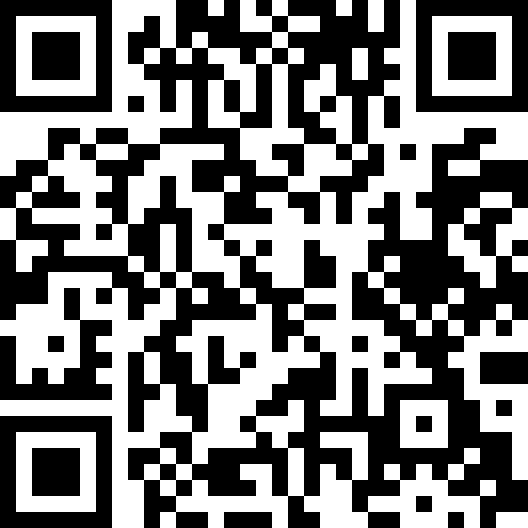

In [10]:
qrcode_img

# QR Code Conditioned ControlNet Models for Stable Diffusion 1.5

In [11]:
# load ControlNet Pre-train
import torch
from diffusers import ControlNetModel, StableDiffusionControlNetImg2ImgPipeline, DDIMScheduler
from diffusers.utils import load_image
from typing import Tuple

In [12]:
controlnet = ControlNetModel.from_pretrained("DionTimmer/controlnet_qrcode-control_v1p_sd15",
                                             torch_dtype=torch.float16)

In [13]:
cn_pipeline = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16

)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [14]:
cn_pipeline.enable_xformers_memory_efficient_attention() # xformers' memory efficient attention is only available for GPU
cn_pipeline.scheduler = DDIMScheduler.from_config(cn_pipeline.scheduler.config)
cn_pipeline.enable_model_cpu_offload()

In [16]:
IMG_WIDTH = 768
IMG_HEIGHT = 768

def resize_for_input_image(input_image: Image, resolution: Tuple[int, int] = (IMG_WIDTH, IMG_HEIGHT)):
  input_image = input_image.convert("RGB")
  img = input_image.resize(resolution, resample = Image.LANCZOS)
  return img

# QR Code Image
condition_image = resize_for_input_image(bg_qrcode_img)
# Init Image: can be any thing
init_image = load_image("./congchua.png")
init_image = resize_for_input_image(init_image)

In [17]:
condition_image.size, init_image.size


((768, 768), (768, 768))

In [18]:
generator = torch.Generator()


  0%|          | 0/100 [00:00<?, ?it/s]

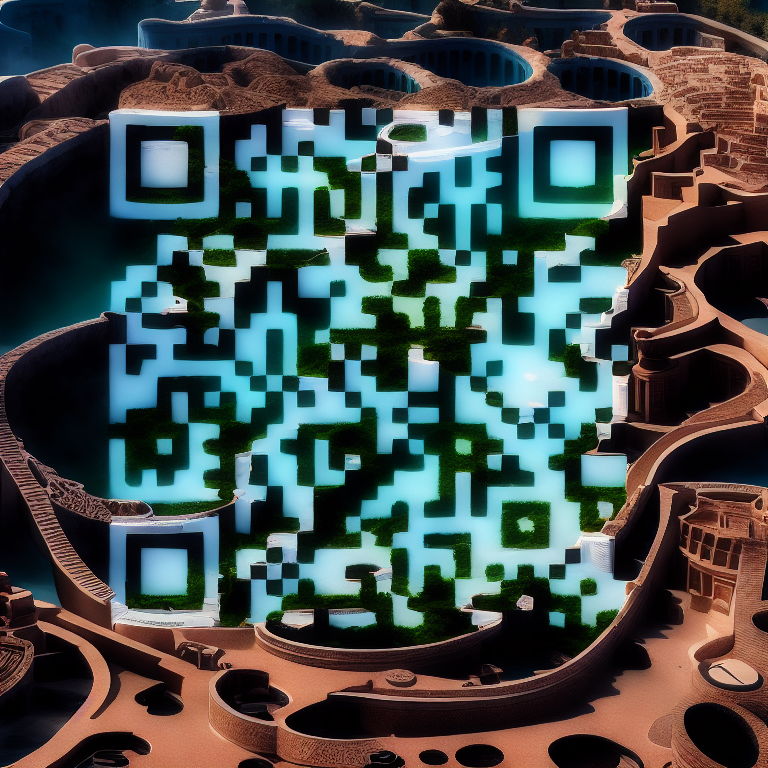

In [20]:
output = cn_pipeline(
    prompt="Sky view of highly aesthetic, ancient greek thermal baths in beautiful nature",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=init_image,
    control_image=condition_image,
    width=IMG_WIDTH,
    height=IMG_HEIGHT,
    guidance_scale=7.5,
    controlnet_conditioning_scale=2.1,
    generator=generator,
    strength=1.0,
    num_inference_steps=100,
)

output.images[0]